# Group Members

This assignment is written by 

    Rui Ning (Ray) Wu       10944156
    Curtis Fox              23673149
    Tianyue (Helen) Zhang   24991151

In [1]:
macro javascript_str(s) display("text/javascript", s); end

@javascript_str (macro with 1 method)

In [2]:
javascript"""
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}"""

# Case Study: Portfolio Optimization
<figure>
  <img src="stocks.png" alt=".." title="Optional title" />
  <figcaption><center>Figure: The historical rate of return of five technology stocks from the beginning of 2012.</center></figcaption>
</figure>

[Modern portfolio theory](http://en.wikipedia.org/wiki/Modern_portfolio_theory) is based on the
[Markowitz](http://en.wikipedia.org/wiki/Harry_Markowitz) model 
for determining a portfolio of stocks with a desired expected rate of
return that has the smallest amount of variance. The main idea is that
by <i>diversifying</i> (investing in a mixture of different stocks),
one can guard against large amounts of variance in the rates of return
of the individual stocks.

Suppose $p_1, \ldots, p_m$ are the historical prices of a stock over
some period of time. We define the "rate of return" at time $t$,
relative to the initial price $p_1$ by

\begin{equation}
	r_t := (p_t - p_1)/p_1, \text{for} \ \ \ t=1,\ldots,m. \ \ \ \ \ \ (1)
\end{equation}

The "expected rate of return" is the mean $\mu$ of the rates of
return, and the "risk" is defined as the <i>standard deviation</i> $\sigma$ of the rates of return:

\begin{equation}
	\mu := \frac{1}{m}\sum_{t = 1}^m r_t
	\ \ \ \text{and} \ \ \ 
	\sigma := \sqrt{\frac{1}{m} \sum_{t=1}^m (r_t - \mu)^2}.
\end{equation}

Given a collection of $n$ stocks, let $r^i_t$ be the rate of return
of stock $i$ at time $t$. Let $r$ be the $n \times 1$ vector of the
expected rates of return of the $n$ stocks. In addition, let
$\Sigma$ be the $n \times n$ $covariance\ matrix$ of the rates of
return of the $n$ stocks. Thus, $r_i$ is the mean of the rates of
return of stock $i$, $\Sigma_{ii}$ is the variance of the rates of
return of stock $i$, and $\Sigma_{ij}$ is the covariance of the rates
of return of stocks $i$ and $j$:

\begin{equation}
	r_i := \frac{1}{m}\sum_{t = 1}^m r_t^i
    \ \ \ \text{and} \ \ \
	\Sigma_{ij} := \frac{1}{m}\sum_{t = 1}^m (r^i_t - r_i)(r^j_t - r_j).
\end{equation}

We let $x_i$ be the fraction of our investment money we put into stock
$i$, for $i = 1,\ldots,n$. For the sake of this study, we assume
there is no "short selling" (i.e., holding a stock in negative
quantity). Thus, $x$ is a vector of length $n$ that has nonnegative
entries that sum to one (i.e., $x \geq 0$ and $\sum_{i=1}^n x_i =
1$). The vector $x$ represents our `portfolio` of investments.
The expected rate of return and standard deviation of a portfolio $x$ are then given by

\begin{equation}
	\mu := r^Tx \ \ \ \text{and}\ \ \ \sigma := \sqrt{x^T \Sigma x}.
\end{equation}




### Exercise 1 (in class)

1.
Download financial data (**csv** files) from [Yahoo! Canada Finance](http://ca.finance.yahoo.com) for the following twenty stocks:

* Technology:  AAPL, IBM, GOOG, MSFT, AABA
* Services:  AMZN, COST, EBAY, TGT, WMT
* Financial:  BMO, BNS, JPM, RY, TD
* Energy:  BP, CVX, IMO, TOT, XOM

Store the **csv** files in a directory called **'data'**.


2.
Complete the function `load_stock(dirname, startdate, enddate)`:

This function must read the `adjusted closing prices` of all stocks in the given directory between the start date and end date, and compute the rates of return as in equation (1).

In [3]:
function load_stocks(dirname, startdate, enddate)
    filenames = readdir(dirname)
    #X = []
    X = []
    dates = []
    names = []
    for i = 1:length(filenames)
        file = filenames[i]
        data = readdlm( string( dirname, "/", file), ',')
        stockDates = data[2:end,1]
        stockDates = Date.(stockDates)
        stockPrices = data[2:end,end-1]

        m = match(r"[A-Z]*", file)
        push!(names, m.match)

        idx1 = (stockDates .> Date(startdate))
        idx2 = (stockDates .< Date(enddate))
        if ~any(idx1)
            error(string("Date ", startdate, " does not exist in data."))
        end
        if ~any(idx2)
            error(string("Date ", enddate, " does not exist in data."))
        end

        idx = find( idx1 .& idx2 )
        prices = stockPrices[idx]
        if i == 1
            X = reshape(X, length(prices), 0)
            dates = stockDates[idx]
        end
        Xi = (prices - prices[1]) ./ prices[1]
        Xi = reshape(Xi, length(prices), 1)
        X = [X Xi]
    end

    return Array{Float64,2}(X), dates, Array{String,1}(names)
end

load_stocks (generic function with 1 method)

Use the following start and end dates:
```
startdate = '2017-01-03'; enddate = '2017-12-31';
```
After you complete `load_stock(dirname, startdate, enddate)` Use the following code to plot your results using the given function `disp_stocks` in `preprocess.jl`

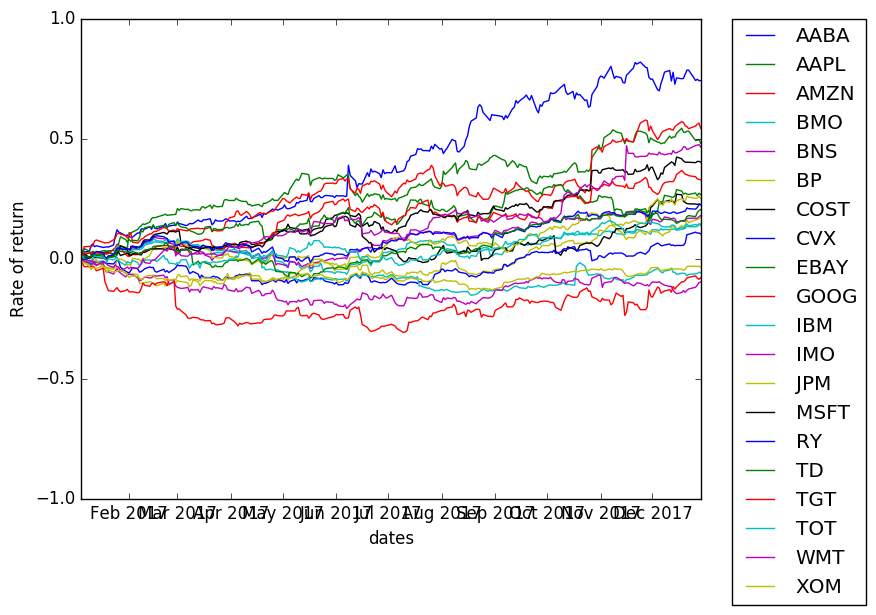

In [4]:
include("preprocess.jl")
using PyPlot
X, dates, names = load_stocks("data", "2017-01-03", "2017-12-31")
disp_stocks(X, dates, names)

3.
Complete function `meancov(X)` that returns the $n \times 1$ vector $r$ of means and the $n \times n$ covariance matrix $Sig$ of the rates of returns of $n$ stocks given by $X$:

In [5]:
function meancov(X)
    return vec( mean(X, 1) ), cov(X)
end

meancov (generic function with 1 method)

After you complete `meancov(X)`, run the following code to get estimated returns and covariance.

In [6]:
r, Sig = meancov(X);

4.
Complete the function `portfolio_scatter(r, Sig, num)`.

This function must generate random portfolios and make a scatter plot
of their expected rates of return and standard deviation. Each random
portfolio is generated by randomly allocating a fraction of the
overall investment among a small set of 5 randomly chosen stocks. Make
a scatter plot with $num = 1000$ points.

In [7]:
function portfolio_scatter(r, Sig, num)
    n = length(r)
    randmu = zeros(num)
    randSig = zeros(num)
    figure()
    for i = 1:num
        k = 5
        #Random select 5 stocks
        inds = randperm(n);
        inds = inds[1:k]
        #Construct weights
        weight = rand(k); weight = weight ./ sum(weight)
        randmu[i] = dot(weight, r[inds])
        randSig[i] = sqrt( (weight' * Sig[inds, inds] * weight)[1,1] )
    end
    plot(randSig, randmu, "b+", markersize = 5)
    xlabel("Std. Dev.")
    ylabel("Expected Rate of Returen")

end

portfolio_scatter (generic function with 1 method)

Run the following code when you complete the function `portfolio_scatter`.

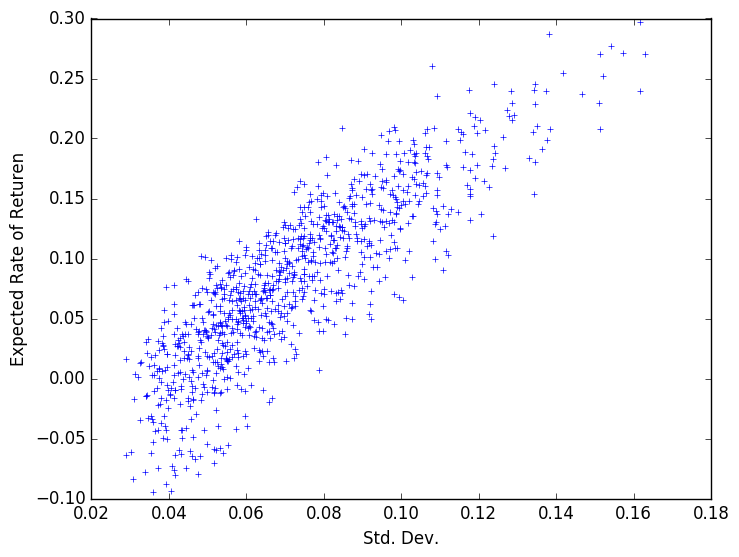

PyObject <matplotlib.text.Text object at 0x7f3797375350>

In [8]:
portfolio_scatter(r, Sig, 1000)

### Exercise 2 (Homework, due by March 22th, 11:59pm)

1.
Use [**JuMP**](https://jump.readthedocs.io/en/latest/)(please read the documentation) to compute the portfolio with minimum risk. What is
  the expected rate of return and standard deviation of this
  portfolio? Plot the rate of return of this portfolio over the entire
  time period. What is the portfolio with maximum possible expected
  rate of return? Complete the function `return_range` that
  returns $num$ linearly spaced rates of return between the
  rate of return of the portfolio with minimum risk and the maximum
  possible rate of return:
  
More about **JuMP**: you can install **JuMP** by 
```
Pkg.add("JuMP")
```
Note that you need to specify a solver for **JuMP** to optimize your problem, here you need to formulate the portfolio optimization problem as a quadratic programming, it can be solved by a free solver `Ipopt`, you are recommended to install `Ipopt` and use that as your solver.
```
Pkg.add("Ipopt.jl")
```
If you are using Ipopt as your solver, you can initialize the model by
```
m = Model(solver = IpoptSolver())
```
When you finish debugging, set `m = Model(solver = IpoptSolver(print_level=0))` to silence IPOPT output.


In [9]:
using JuMP
using Ipopt
function return_range(r, Sig, num)
    n = length(r)
    
    # min_risk
    min_risk = Model(solver = IpoptSolver(print_level=0))
    @variable(min_risk, x[1:n] >= 0)
    @constraint(min_risk, sum(x) == 1);
    @objective(min_risk, Min, x'*Sig*x);
    
    status = solve(min_risk)

    x_value = getvalue(x);
    min_risk_obj = r'*x_value
        
    # max_return
    max_return = Model(solver = IpoptSolver(print_level=0))
    @variable(max_return, w[1:n] >= 0)
    @constraint(max_return, sum(w) == 1);
    @objective(max_return, Max, w'r);
    
    status = solve(max_return)

    w_value = getvalue(w);
    max_return_obj = r'*w_value
        
    return collect(linspace(min_risk_obj, max_return_obj, num))
end

return_range (generic function with 1 method)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Portfolio with minimum risk: 


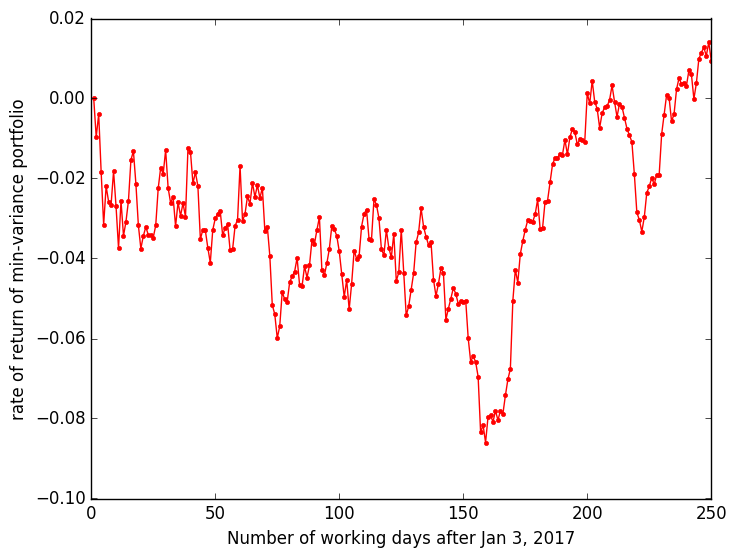

20-element Array{Float64,1}:
 1.21024e-6
 3.00776e-5
 2.47627e-6
 7.32827e-6
 7.76576e-6
 2.07377e-6
 6.92898e-6
 3.0827e-6 
 0.155488  
 5.84001e-6
 0.141411  
 1.25213e-5
 2.48258e-6
 2.10277e-6
 4.4107e-6 
 2.36505e-6
 4.13417e-6
 5.80004e-6
 1.67785e-6
 0.702999  

In [10]:
# Model with minimum risk
n = length(r);
min_risk = Model(solver = IpoptSolver(print_level=0))
@variable(min_risk, x[1:n] >= 0)
@constraint(min_risk, sum(x) == 1);
@objective(min_risk, Min, x'*Sig*x);
status = solve(min_risk)

min_risk = getvalue(x);

(tr, o) = size(X);
tr = collect(linspace(1, tr, tr));
yr = X*min_risk # objective value over time

plot(tr, yr, "r.-")
xlabel("Number of working days after Jan 3, 2017")
ylabel("rate of return of min-variance portfolio")
println("Portfolio with minimum risk: ")
min_risk

In [11]:
# max_return
max_return = Model(solver = IpoptSolver(print_level=0))
@variable(max_return, w[1:n] >= 0)
@constraint(max_return, sum(w) == 1);
@objective(max_return, Max, w'r);
status = solve(max_return)
max_return = getvalue(w);
max_return_obj = r'*max_return
print("Objective value of maximum return: ")
println(max_return_obj);
println("Portfolio with maximum return: ")
max_return


Objective value of maximum return: 0.4119370764429054
Portfolio with maximum return: 


20-element Array{Float64,1}:
 1.0        
 1.47321e-8 
 8.96155e-9 
 0.0        
 0.0        
 0.0        
 0.0        
 0.0        
 7.50902e-10
 4.48176e-10
 0.0        
 0.0        
 0.0        
 3.71527e-10
 0.0        
 0.0        
 0.0        
 0.0        
 0.0        
 0.0        

Run the following code when you complete `return_range`.

In [12]:
rrange = return_range(r, Sig, 12);

2.
Given a desired expected rate of return, we can see from the
  scatter plot that there are many portfolios that we can choose that
  have this expected rate of return. However, each of these portfolios
  have a different level of risk, or standard deviation. Among these,
  the most $efficient$ portfolio is the one giving us the least
  amount of risk.

  Each expected rate of return determines a different efficient
  portfolio. Plotting the expected rate of return and standard
  deviation of each of the efficient portfolios will give us a curve
  called the **efficient frontier**.
  
  Complete the function `efficient_frontier(r, Sig, num)`
```
Y, rates, sigs = efficient_frontier(r, Sig, num)
```
This function will compute $num$ efficient portfolios with
linearly spaced rates of return (obtained from
`return_range`). These portfolios will be stored in the
$n \times num$ matrix $Y$, and their
corresponding expected rates of return and standard deviation in
vectors $rates$ and $sigs$. Plot $sigs$ and
$rates$ on the scatter plot, with $num = 12$:


In [13]:
function efficient_frontier(r, Sig, num)
    n = length(r)
    rrange = return_range(r, Sig, num)
    sqrtSig = sqrtm(Sig)
    Y = zeros(n, num)
    sigs = zeros(size(rrange));
    rates = rrange;
    
    for jj = 1:num
        # complete the code
        rate = rrange[jj];
        m = Model(solver = IpoptSolver(print_level=0))
        @variable(m, w[1:n] >= 0)
        @constraint(m, sum(w) == 1);
        @constraint(m, w'r == rate);
        @objective(m, Min, w'*Sig*w);

        status = solve(m)
        var = getobjectivevalue(m)
        w_value = getvalue(w);
        m_obj = r'*w_value

        sigs[jj] = sqrt(var)
        Y[:,jj] = w_value;
    end
    
    return Y, rates, sigs
end

efficient_frontier (generic function with 1 method)

Run the following code after you complete the function `efficient_frontier`

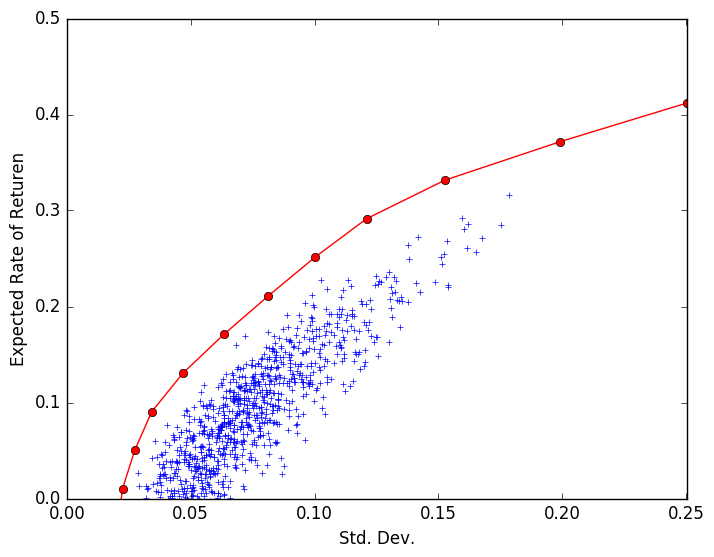

(0, 0.25035193402220884)

In [14]:
figure()
portfolio_scatter(r, Sig, 1000)
num = 12
Y, rates, sigs = efficient_frontier(r, Sig, num);
plot(sigs, rates, "ro-"); 
ylim(0, 0.5)
xlim(0, maximum(sigs))

Display your results using the given function `disp_portfolios(Y, rates, sigs, names)`

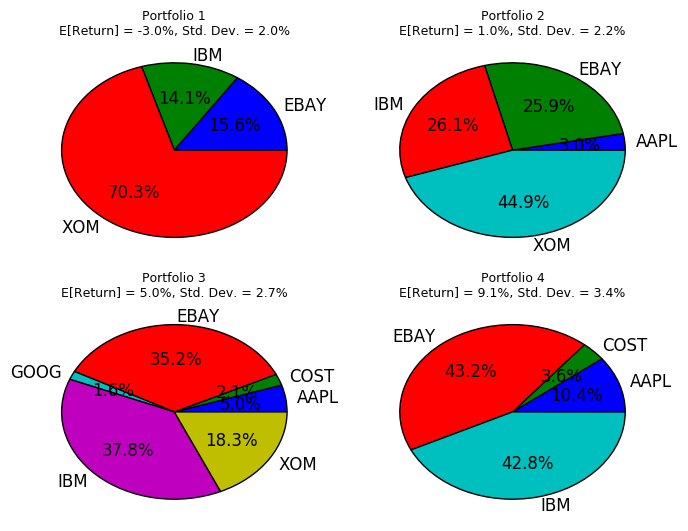

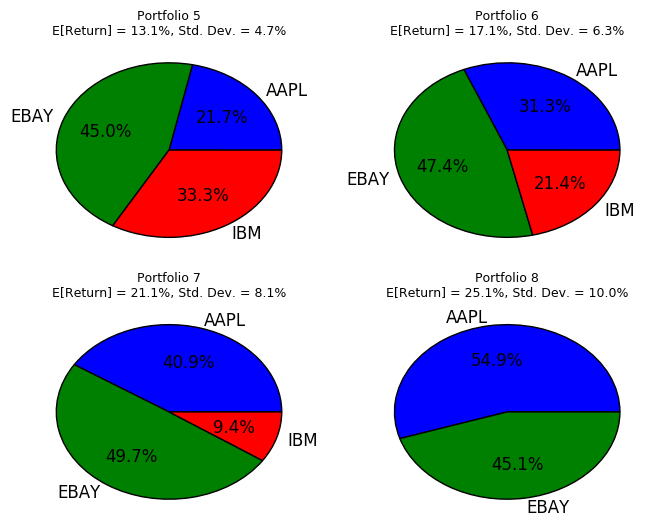

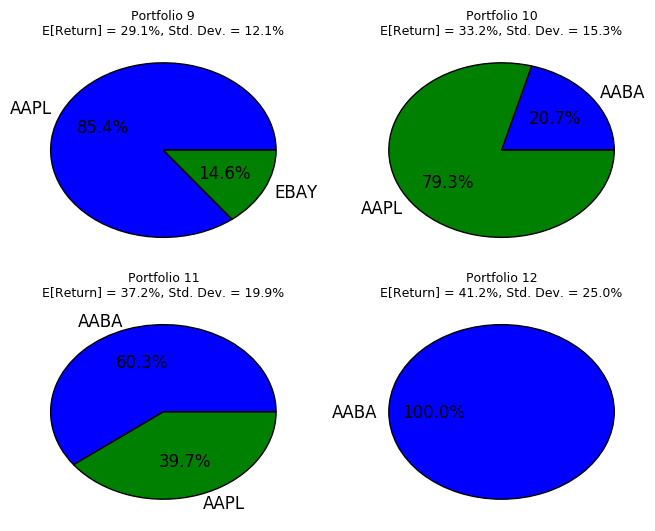


   Portfolio      1      2      3      4      5      6      7      8      9     10     11     12
------------------------------------------------------------------------------------------------
     1  AABA    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   20.7   60.3  100.0
     2  AAPL    0.0    3.0    5.0   10.4   21.7   31.3   40.9   54.9   85.4   79.3   39.7    0.0
     3  AMZN    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     4   BMO    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     5   BNS    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     6    BP    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     7  COST    0.0    0.0    2.1    3.6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     8   CVX    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
     9  EBAY   15.6   25.9   

In [16]:
include("preprocess.jl")
disp_portfolios(Y, rates, sigs, names)

### Exercise 3 (Homework, due by March 22th, 11:59pm)

Add a risk-free investment called 'RF' to the collection of stocks with a 3% rate of return. Use your `efficient_frontier` code from Exercise 2 to determine the new efficient frontier and plot it on the same plot with the original efficient frontier. You will notice that the new efficient frontier has two pieces: (1) a linear piece, and (2) a nonlinear piece that coincides with the original efficient frontier. What does the linear piece represent? 

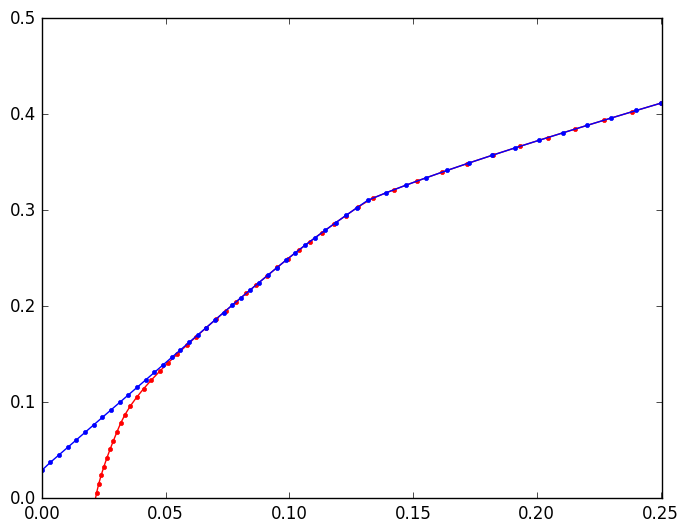

(0, 0.2505708896127236)

In [17]:
num = 50
f = 0.03
# complete the code 
Y, rates, sigs = efficient_frontier(r, Sig, num);
plot(sigs, rates, "r.-"); 
ylim(0, 0.5)
xlim(0, maximum(sigs)+minimum(sigs))

rp = [r; f];
Sigp = [Sig zeros(20, 1); zeros(1,21)]
Y, rates, sigs = efficient_frontier(rp, Sigp, num);
plot(sigs, rates, "b.-"); 
ylim(0, 0.5)
xlim(0, maximum(sigs)+minimum(sigs))

$\textbf{Student Answer:}$ The linear part represents using the risk-free investment 

The portfolio where these two pieces join is called the "market portfolio". Complete the function `market_portfolio(f, r, Sig)` that computes the market portfolio corresponding to a risk-free rate of return $f$:

Use `IpoptSolver` for the function `market_portfolio` (quadratic programming with linear constraints) and use `SCSSolver` for the function `risk_free_rate`. (linear programming with quadratic constraints)

You can use `Model(solver = SCSSolver(verbose=0))` to silent SCS output.

In [18]:
# Exercise 3

function market_portfolio(f, r, Sig)

    # Define function func such that func(sig) = 0 when risk_free_rate(sig, r, Sig) = f.
    func(sig) = (risk_free_rate(sig,r,Sig) - f);
    
    # Compute the minimum value of sig
    sig1 = 0.03;
    minval = func(sig1);
    h = 0.01;
    while (h > 1e-7)
        next = func(sig1 - h);
        if (next < minval)
            minval = next;
            sig1 = sig1 - h;
        else
            h = h/2;
        end
    end
    
    # Compute the maximum value of sig
    sig2 = 0.03;
    minval = func(sig2);
    h = 10;
    while (h > 1e-7)
        next = func(sig2 + h);
        if (next > minval)
            minval = next;
            sig2 = sig2 + h;
        else
            h = h/2;
        end
    end
    
    # Use BinarySearch to solve func(sig) = 0
    sig = BinarySearch(func, sig1, sig2)
    
    # The market portfolio is the portfolio on the efficient frontier with risk
    # equal to the sig satisfying   risk_free_rate(sig, r, Sig) = f.
    
    n = length(r);
    market = Model(solver = IpoptSolver(print_level=0))
    @variable(market, x[1:n] >= 0)
    @constraint(market, sum(x) == 1)
    @objective(market, Max, r'x)
    @constraint(market, x'*Sig*x == sig^2)
    
    status = solve(market)
    weights = getvalue(x)
    
    return weights;    
end

function risk_free_rate(sig, r, Sig)
    n = length(r)
    sqrtSig = sqrtm(Sig)
    
    # Dual multiplier lambda gives slope of efficient frontier at the point
    # (r'*x, sqrt(x'*Sig*x)), where x is the portfolio with maximum expected
    # rate of return with risk at most sig.    
    m = Model(solver = SCSSolver(verbose=0))
    @variable(m, x[1:n] >= 0)
    @objective(m, Max, r'*x)
    @constraint(m, sum(x) == 1)
    @constraint(m, soc, norm(sqrtSig*x) <= sig)

    status = solve(m)
    weights = getvalue(x)
    dualvar = getdual(soc)
    lambda = dualvar[1]
    
    # The risk-free rate is the y-intercept of the line tangent to the 
    # efficient frontier at the point (r'*x, sqrt(x'*Sig*x))
    rate = (r'*weights)-lambda*sqrt(weights'*Sig*weights)  # complete the code 
    
    return rate
end

function BinarySearch(func, x1, x2)
    # This is a generic binary search routine.
    # Given x1 and x2, with.
    #    func(x1) < 0  and  func(x2) > 0, or
    #    func(x1) > 0  and  func(x2) < 0,
    # returns x with abs(func(x)) < 1e-6.
    @printf "Binary search:\n"
    if func(x1) > 0 && func(x2) < 0
        # Swap x1 and x2
        tmp = x1
        x1 = x2
        x2 = tmp
    end
    ii = 0; y = Inf
    @printf "%4s%10s%10s\n" "Iter" "x" "|f(x)|"
    x = 0
    while abs(y) > 1e-6 && ii <= 30
        ii += 1; x = (x1 + x2)/2; y = func(x)
        @printf "%4d%10.2e%10.2e\n" ii x abs(y)
        if y < 0
            x1 = x
        else
            x2 = x
        end
    end
    @printf "Done."
    return x
end

BinarySearch (generic function with 1 method)

Run the following code after you complete the above functions.

In [19]:
using SCS
f = 0.03
x = market_portfolio(f, r, Sig);

Binary search:
Iter         x    |f(x)|
   1  2.07e+01  3.82e-01
   2  1.03e+01  3.82e-01
   3  5.18e+00  3.82e-01
   4  2.60e+00  3.82e-01
   5  1.31e+00  3.82e-01
   6  6.65e-01  3.82e-01
   7  3.43e-01  3.82e-01
   8  1.82e-01  1.74e-01
   9  1.01e-01  1.70e-02
  10  6.08e-02  7.10e-03
  11  8.09e-02  3.54e-03
  12  7.09e-02  8.40e-04
  13  7.59e-02  1.54e-03
  14  7.34e-02  3.57e-04
  15  7.21e-02  2.27e-04
  16  7.27e-02  6.83e-05
  17  7.24e-02  7.83e-05
  18  7.26e-02  4.78e-06
  19  7.27e-02  3.18e-05
  20  7.26e-02  1.35e-05
  21  7.26e-02  4.38e-06
  22  7.26e-02  2.04e-07
Done.

Plot the line that is tangent to the original efficient frontier at the market portfolio. What does the top half of this tangent line represent?


In [20]:
# complete the code and plot the figure

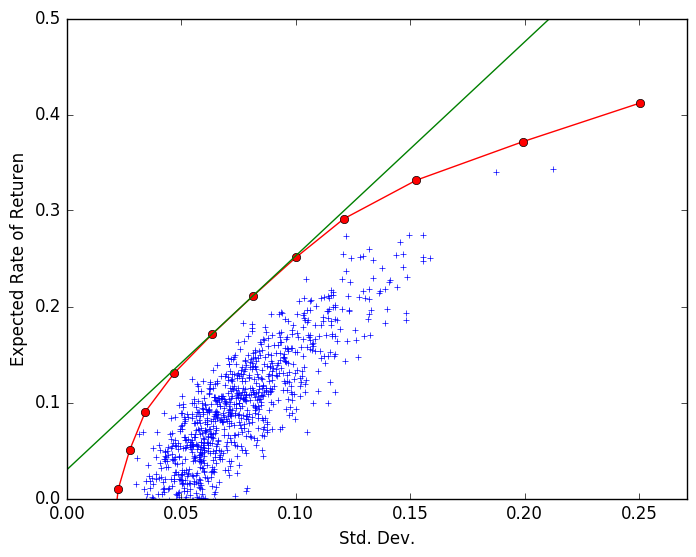

(0, 0.27084102359818696)

In [22]:
figure()
portfolio_scatter(r, Sig, 1000)
num = 12
Y, rates, sigs = efficient_frontier(r, Sig, num);

plot(sigs, rates, "ro-");

x0 = 0

y1 = r'*x
x1 = sqrt(x'*Sig*x)

y0 = risk_free_rate(x1, r, Sig);

slope = (y1-y0)/(x1-x0);

xv = collect(linspace(0, maximum(sigs)+minimum(sigs)));
yv = slope*xv + y0;

plot(xv, yv, "g-")

ylim(0, 0.5)
xlim(0, maximum(sigs)+minimum(sigs))

$\textbf{Student Answer:}$ Bottom half of the tangent line represents using the risk-free investment, and where the line touches the efficient frontier represents no risk-free investment, so top half of the tangent line must represent negative usage of the risk-free investment. 

Negative usage of a risk-free investment can be interpreted as follows: If the risk-free investment is like a GIC at a bank, for example, then negative usage of the risk-free investment corresponds to taking out a loan from a bank. And this makes sense because if you can take out a loan from a bank and invest in stocks that have higher rate of returns than the bank does, you are doing better than if that option didn't exist, but at the cost of increased variance. 